# Download all data from synapse and save into file structure

In [1]:
import synapseclient
import synapseutils
import pickle
from matplotlib import pyplot as plt
%matplotlib inline

#login to synapse

syn = synapseclient.Synapse()
syn.login('username','password') ### do not publish password!!!

In [2]:
# # download dicoms into 'files' - takes ~10 minutes; couldn't figure out how to suppress warnings

files = synapseutils.syncFromSynapse(syn, 'syn20608511')

In [3]:
# save file metadata into a pickle so you don't have to re-download it

filename = 'all_data'
outfile = open(filename,'wb')
pickle.dump(files,outfile)
outfile.close()

In [4]:
# load file metadata

files=pickle.load( open( "all_data", "rb" ) )

In [5]:
# load segmentation masks

import zipfile

seg_zip=files[1998].path
archive = zipfile.ZipFile(seg_zip, 'r')
archive.extractall(path='/home/jupyter')

In [10]:
# examine metadata, select dicoms

print(len(files))
print(files[20])
dicoms=[x for x in files if 'dcm' in x.path]
len(dicoms)

1999
File: 001-25.0.dcm (syn20705924)
  md5=344394361df92b498dc3a6a3c5694391
  fileSize=718226
  contentType=application/dicom
  externalURL=None
  cacheDir=/home/jupyter/.synapseCache/713/42802713
  files=['001-25.0.dcm']
  path=/home/jupyter/.synapseCache/713/42802713/001-25.0.dcm
  synapseStore=True
properties:
  concreteType=org.sagebionetworks.repo.model.FileEntity
  createdBy=3342573
  createdOn=2019-09-04T05:11:52.020Z
  dataFileHandleId=42802713
  etag=fc04e4d4-d0a5-41b4-b30c-45de9179ee8b
  id=syn20705924
  modifiedBy=3342573
  modifiedOn=2019-09-06T21:41:47.597Z
  name=001-25.0.dcm
  parentId=syn20705917
  versionLabel=1
  versionNumber=1
annotations:
  assay=['MRI']
  dataSubtype=['raw']
  dataType=['image']
  diagnosis=['Schwannomatosis']
  experimentalCondition=['*tse2d1_3']
  fileFormat=['DICOM']
  fundingAgency=['CTF, DoD, NIH']
  individualID=['MGH_WBMRI_patient_010']
  individualId=['MGH_WBMRI_patient_010']
  isCellLine=['FALSE']
  nf1Genotype=['unknown']
  nf2Genotype=

1899

In [12]:
# separate dicoms into STIRs and T1s

stirs=[x for x in dicoms if 'tir' in x.experimentalCondition[0]]
t1s=[x for x in dicoms if 'tse' in x.experimentalCondition[0]]
print(len(stirs), len(t1s))

# 052 doesn't have T1

960 939


## Examine images

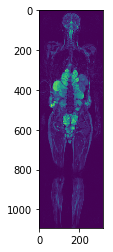

In [83]:
# show one image

import skimage as sk
import pydicom
test_img=pydicom.dcmread(files[1210].path)

plt.imshow(test_img.pixel_array)

In [85]:
# load matching segmentation

import nibabel as nib

# seg=nib.load('/home/jupyter/segmentation_50cases/segmentation-107.nii.gz')
seg=nib.load(folder_path+'/'+this_patient+'_seg.nii.gz')
seg

[[-1.5625  0.      0.     -0.    ]
 [ 0.     -1.5625  0.     -0.    ]
 [ 0.      0.     10.      0.    ]
 [ 0.      0.      0.      1.    ]]
(321, 1093, 20)


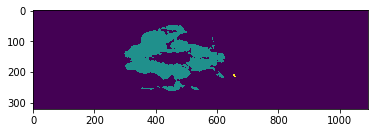

In [89]:
# examine segmentation

img=seg.get_data()
print(seg.affine)
print(img.shape)
plt.imshow(img[:,:,10])

# need to rotate this and re-save

## Place create niftis, place into an organize folder structure

In [27]:
# exclude patients 32, 36 and 52 for incomplete data
patients=['107', '053', '023', '010', '102', '123', '097', 
      '087', '048', '089', '222', '077', '065', '106', '098', 
      '158', '035', '081', '127', '119', '120', '268', '090', 
      '085', '224', '144', '114', '225', '063', '099', '279', 
      '019', '045', '088', '196', '095', '227', '136', '069', 
      '109', '076', '046', '061', '072', '027', '138', '047']
patients.sort()

In [20]:
# create NIFTIs from dicoms, place into directory structure for reference in later notebooks

import os
from shutil import copyfile
import dcmstack
from glob import glob

prefix='/home/jupyter/WBMRI'

seg_path='/home/jupyter/segmentation_50cases/segmentation-'

for this_patient in patients:
    folder_path=prefix+this_patient
    
    #make directory
    #os.mkdir(folder_path)
    
    #get file paths for that patient
    stir_file_paths=[x.path for x in stirs if this_patient in x.individualID[0]]
    stir_file_names=[x.files[0] for x in stirs if this_patient in x.individualID[0]]
    t1_file_paths=[x.path for x in t1s if this_patient in x.individualID[0]]
    t1_file_names=[x.files[0] for x in t1s if this_patient in x.individualID[0]]
    
    #create NIFTIs and place in directory
    my_stack = dcmstack.DicomStack()
    for i in range(0,len(stir_file_paths)):
        src_dcm = pydicom.dcmread(stir_file_paths[i])
        my_stack.add_dcm(src_dcm)
    
    nii = my_stack.to_nifti(voxel_order='SLA')
    nii.to_filename(folder_path+'/'+this_patient+'_stir.nii')
       
    my_stack = dcmstack.DicomStack()
    for i in range(0,len(t1_file_paths)):
        src_dcm = pydicom.dcmread(t1_file_paths[i])
        my_stack.add_dcm(src_dcm)
    
    nii = my_stack.to_nifti(voxel_order='SLA')
    nii.to_filename(folder_path+'/'+this_patient+'_t1.nii')

    os.rename(seg_path+this_patient+'.nii.gz', folder_path+'/'+this_patient+'_seg.nii.gz')

In [33]:
# create resampled T1 images so they align to STIRs and segmentations

import numpy as np
from nilearn.image import resample_to_img

for this_patient in patients:
    folder_path=prefix+this_patient
    stir=nib.load(folder_path+'/'+this_patient+'_stir.nii')
    t1=nib.load(folder_path+'/'+this_patient+'_t1.nii')
    resampled_t1 = resample_to_img(t1, stir)
    print(stir.shape, t1.shape, resampled_t1.shape)
    resampled_t1.to_filename(folder_path+'/'+this_patient+'_t1r.nii')


In [151]:
# flip and rotate seg's to match STIRs

import math

for this_patient in patients:
    folder_path=prefix+this_patient
    seg=nib.load(folder_path+'/'+this_patient+'_seg.nii.gz')
    seg_affine=seg.affine
    seg_data=seg.get_data()
    
    seg_rot_data=np.rot90(seg_data, k=1, axes=(0,1))
    
    seg_rot_rot=np.rot90(seg_rot_data, k=2, axes=(1,2))
    
    seg_flip_data=np.fliplr(seg_rot_rot)

    seg_fliprot_vol=nib.Nifti1Image(seg_flip_data, seg_affine)
    nib.save(seg_fliprot_vol, folder_path+'/'+this_patient+'_seg_rot.nii')

In [152]:
seg_fliprot_vol.shape

(1060, 323, 20)

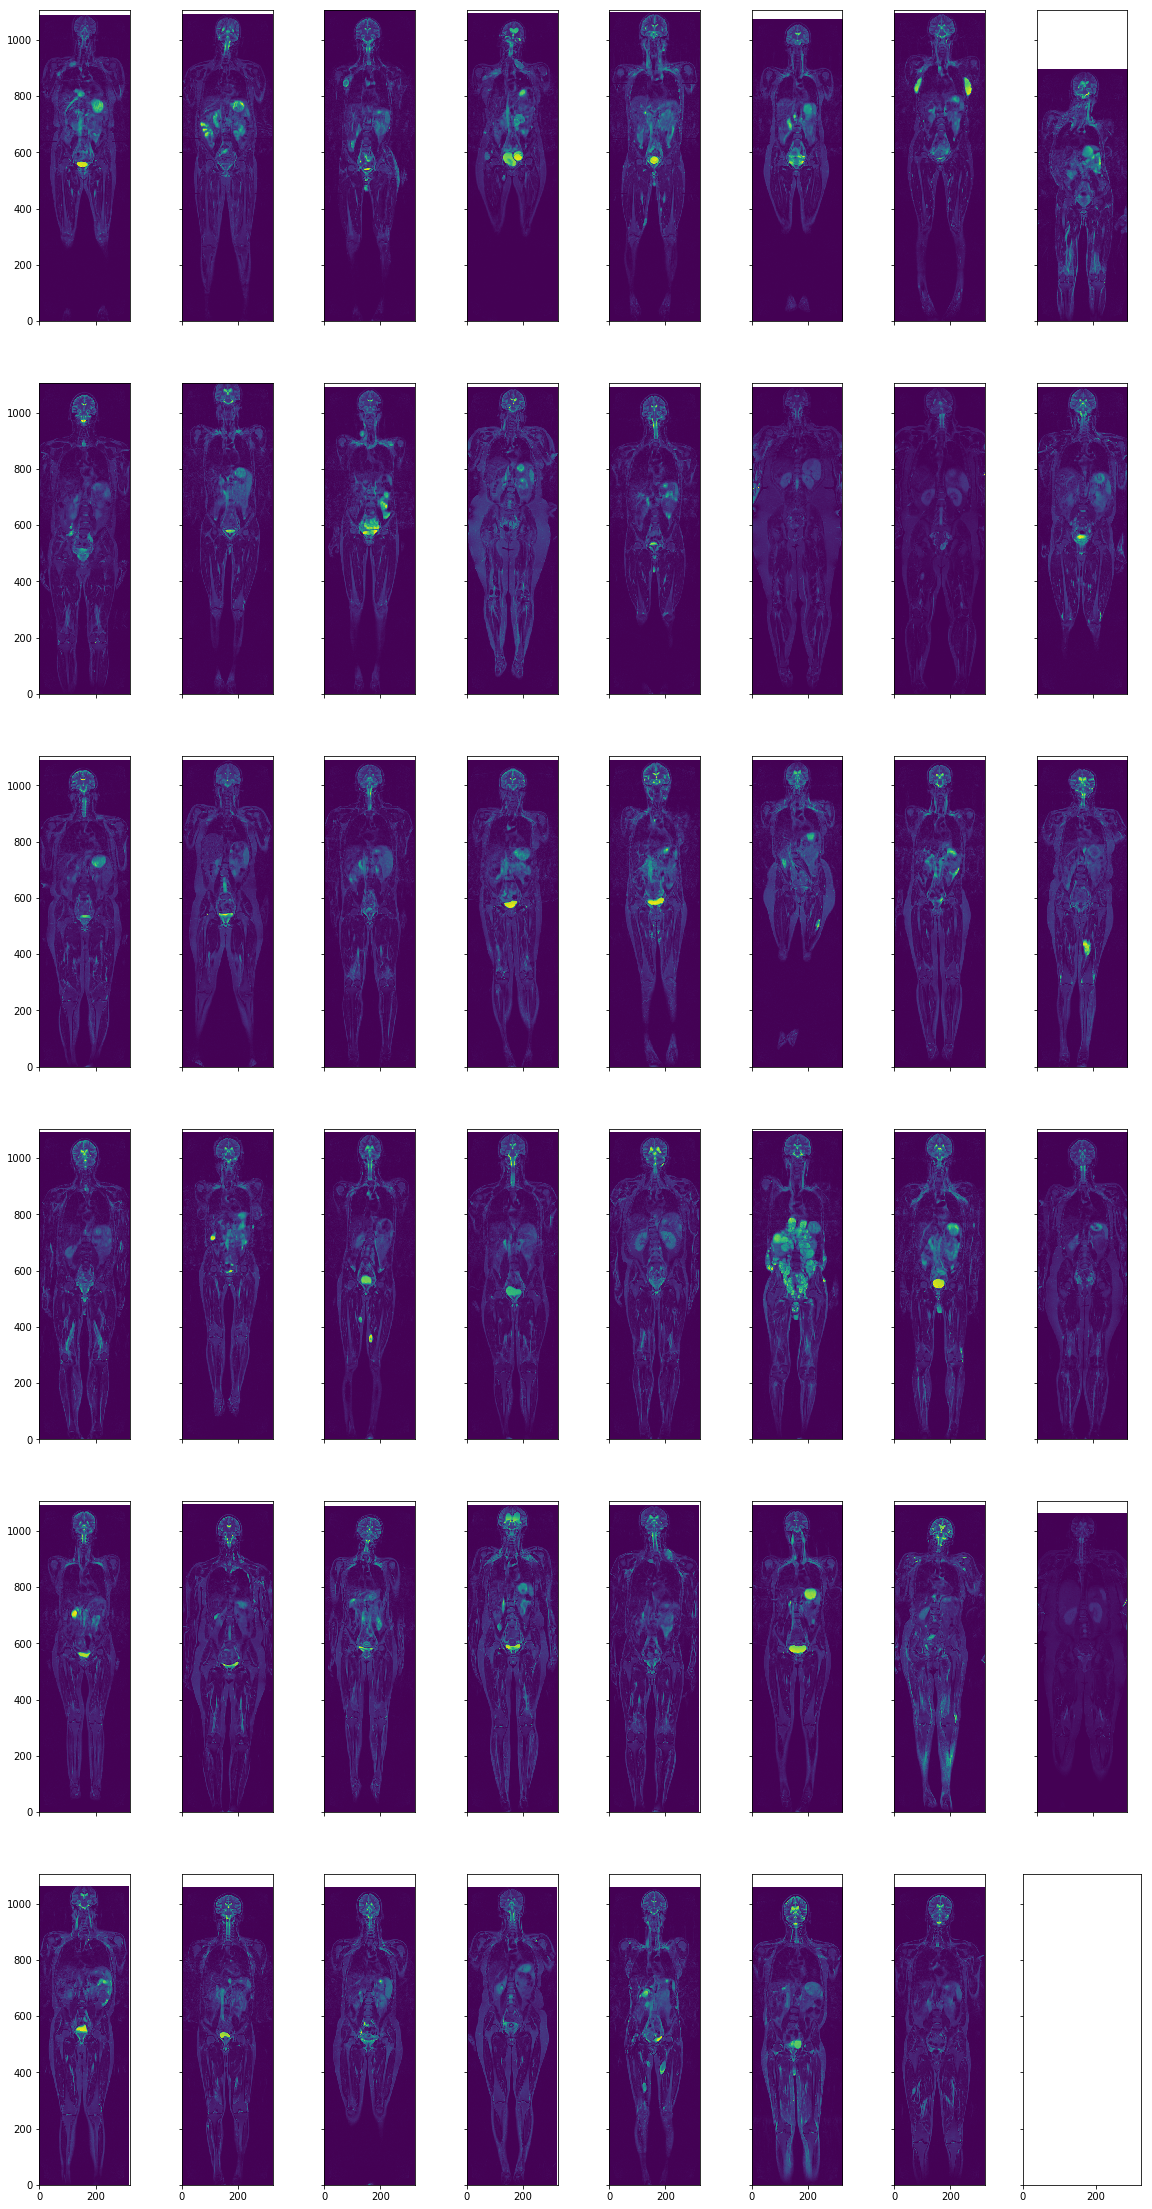

In [28]:
# look at all STIRs

fig, ax = plt.subplots(6, 8, sharex='col', sharey='row', figsize=(20,40))
k=0
for i in range(0,6):
    for j in range(0,8):
        this_patient=patients[k]
        folder_path=prefix+this_patient
        stir=nib.load(folder_path+'/'+this_patient+'_stir.nii')
        stir_data = stir.get_fdata()
        stir_data[stir_data>4000]=0                      # you can remove the measurement lines by thresholding them out
        ax[i,j].imshow(stir_data[:,:,10])#, cmap='gray')
        ax[i,j].set_xlim([0,323])
        ax[i,j].set_ylim([0,1105])
        k+=1
        if k==47:
            break

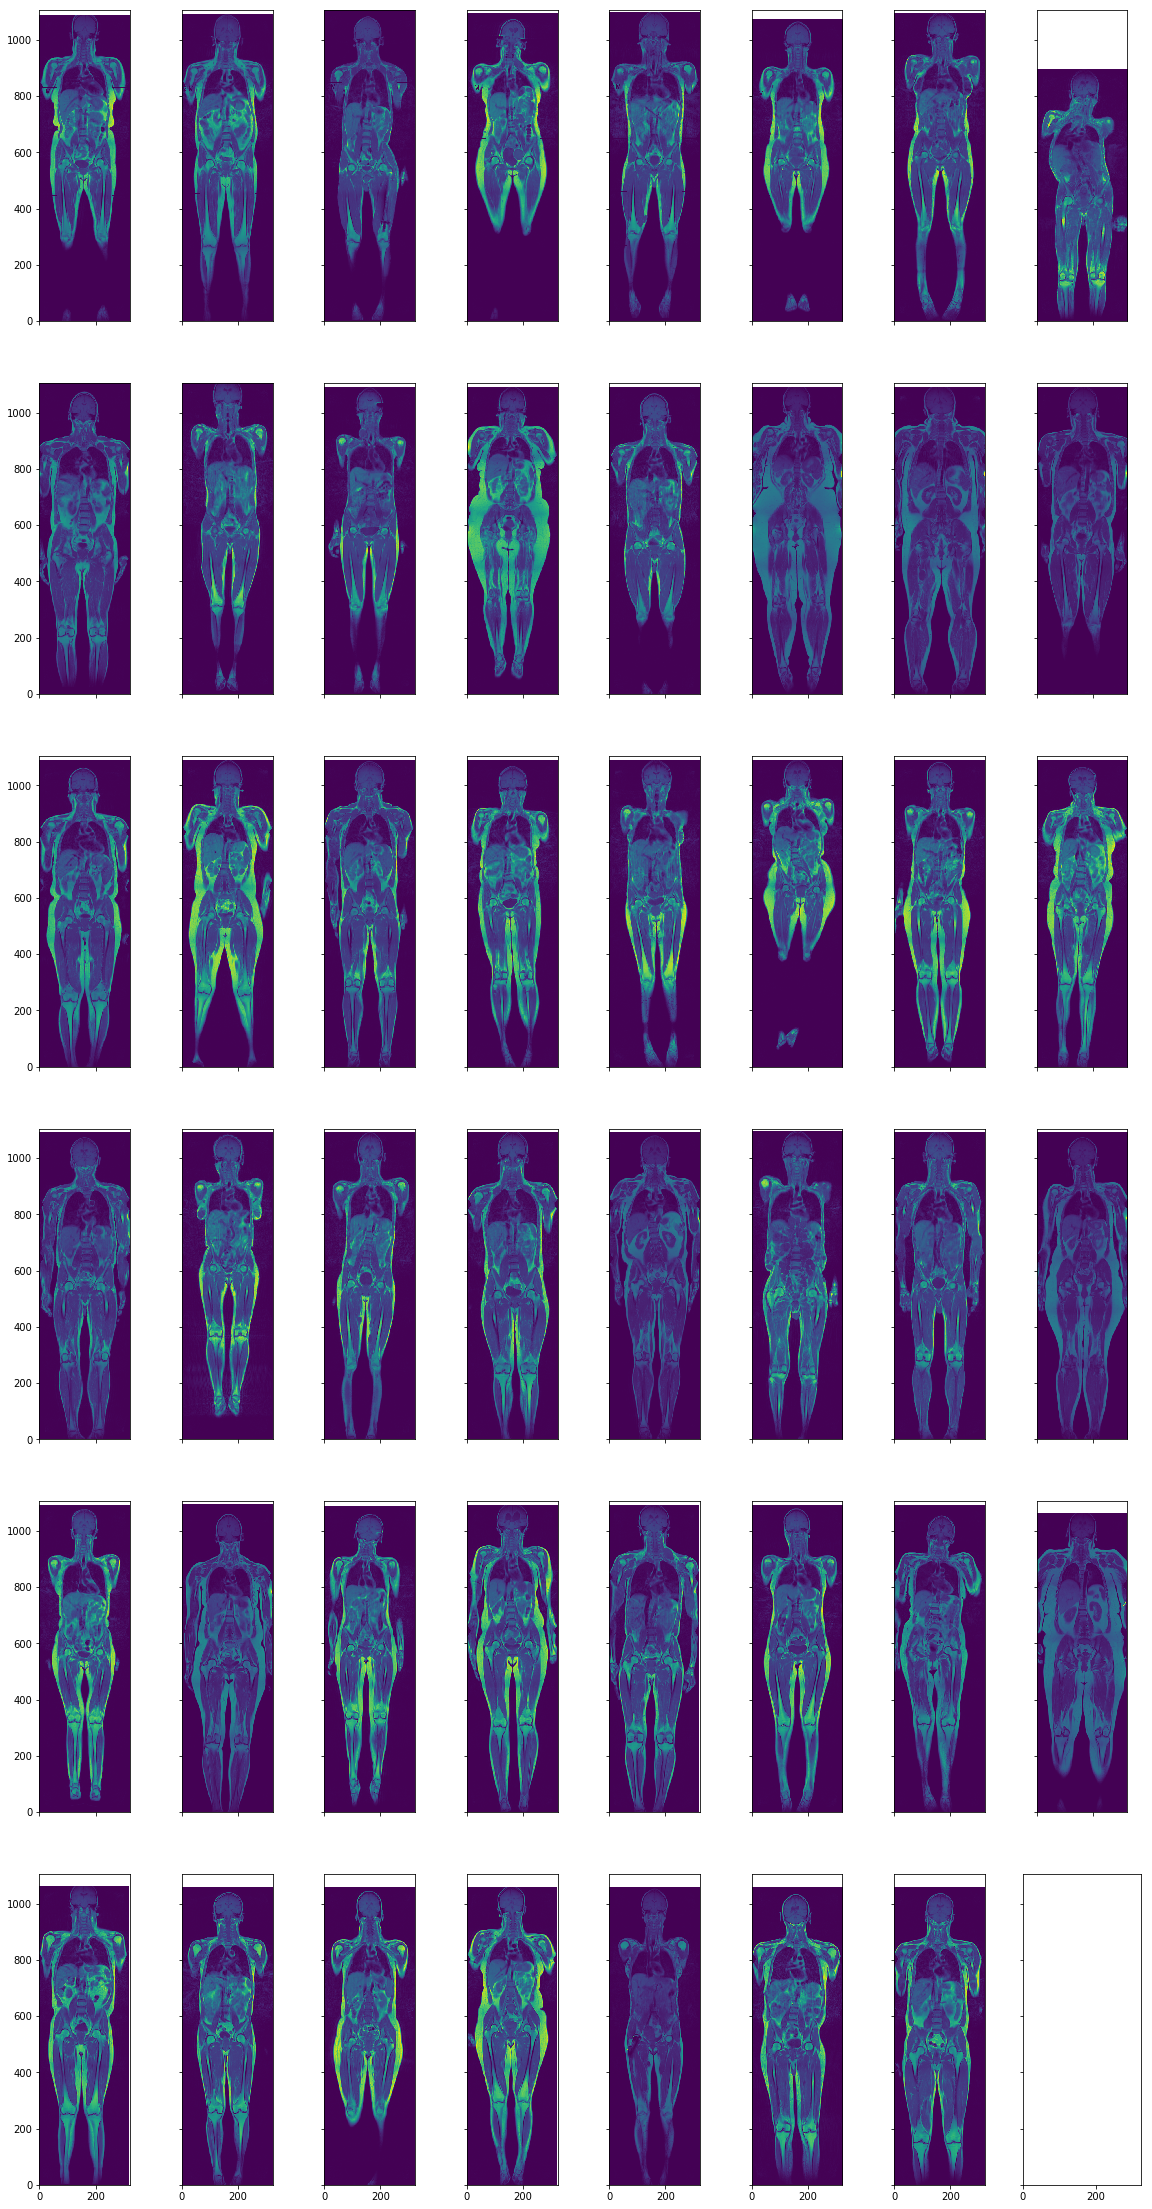

In [29]:
# look at all T1's

fig, ax = plt.subplots(6, 8, sharex='col', sharey='row', figsize=(20,40))
k=0
for i in range(0,6):
    for j in range(0,8):
        this_patient=patients[k]
        folder_path=prefix+this_patient
        stir=nib.load(folder_path+'/'+this_patient+'_t1r.nii')
        stir_data = stir.get_fdata()
        stir_data[stir_data>4000]=0
        ax[i,j].imshow(stir_data[:,:,10])#, cmap='gray')
        ax[i,j].set_xlim([0,323])
        ax[i,j].set_ylim([0,1105])
        k+=1
        if k==47:
            break

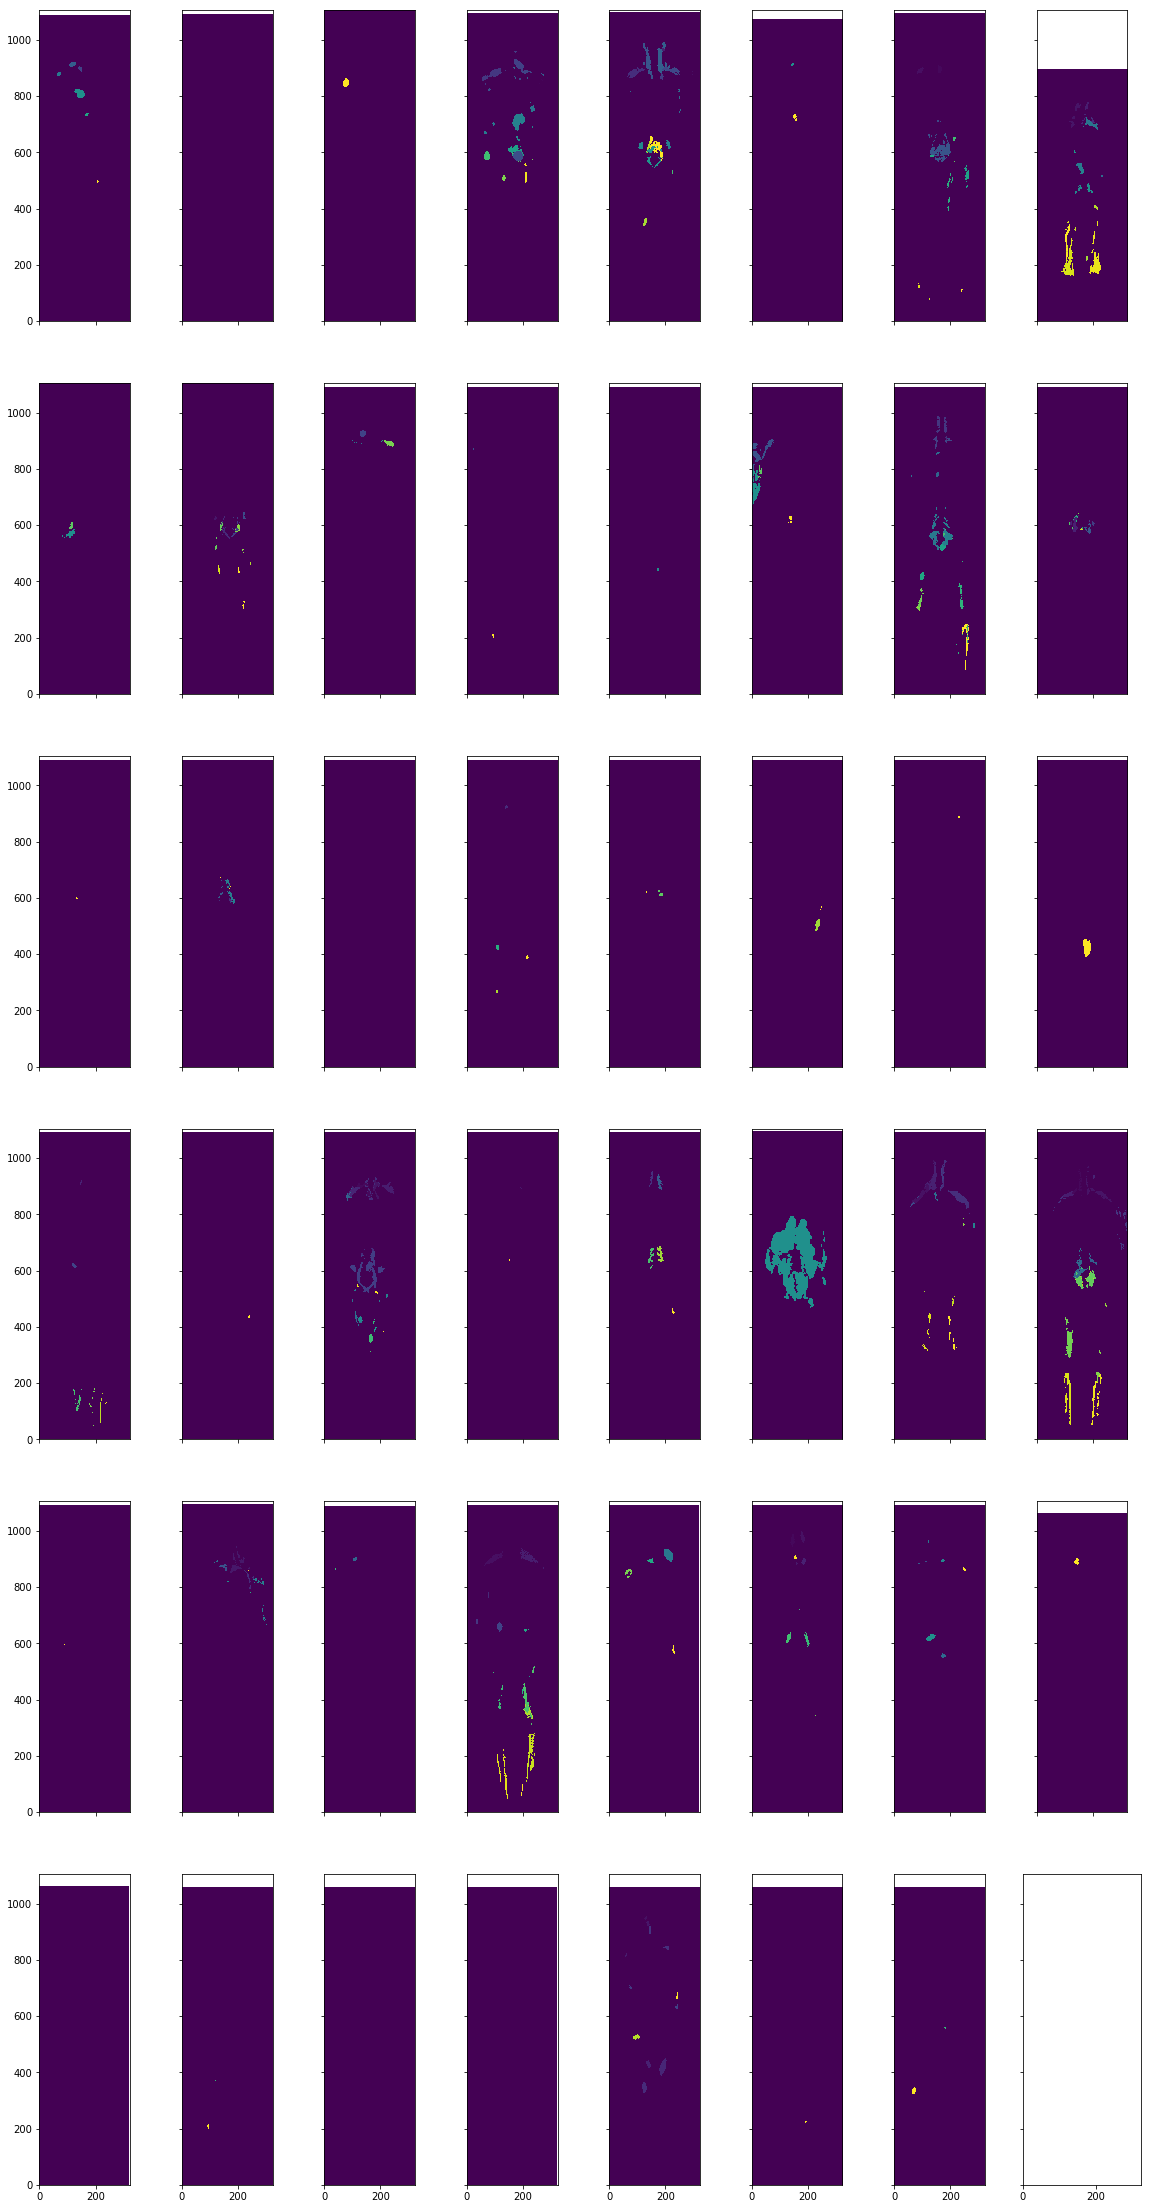

In [155]:
# look at all segs

fig, ax = plt.subplots(6, 8, sharex='col', sharey='row', figsize=(20,40))
k=0
for i in range(0,6):
    for j in range(0,8):
        this_patient=patients[k]
        folder_path=prefix+this_patient
        stir=nib.load(folder_path+'/'+this_patient+'_seg_rot.nii')
        stir_data = stir.get_fdata()
        stir_data[stir_data>4000]=0
        ax[i,j].imshow(stir_data[:,:,10])#, cmap='gray')
        ax[i,j].set_xlim([0,323])
        ax[i,j].set_ylim([0,1105])
        k+=1
        if k==47:
            break

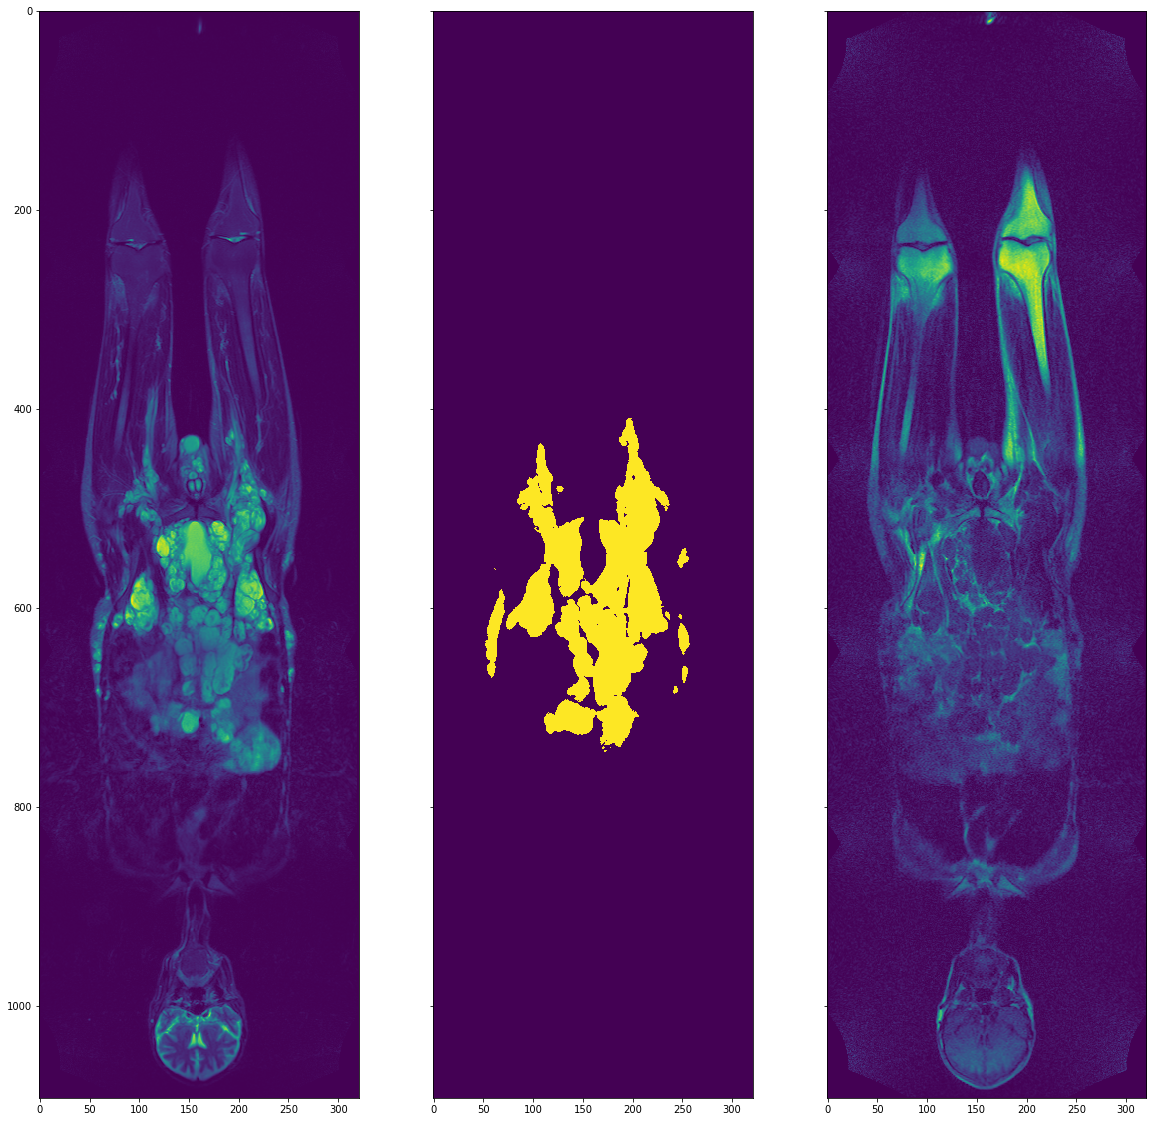

In [157]:
# look at orientation of segs

this_patient='107'
folder_path=prefix+this_patient

stir=nib.load(folder_path+'/'+this_patient+'_stir.nii')
t1=nib.load(folder_path+'/'+this_patient+'_t1r.nii')
seg=nib.load(folder_path+'/'+this_patient+'_seg_rot.nii')

stir_data = stir.get_fdata()
t1_data = t1.get_fdata()
seg_data = seg.get_fdata()
#seg_data=seg_data.swapaxes(0,1)                # this data is oriented differently than the t1's and stirs
#seg_data=np.flipud(seg_data)                   # keep this in mind for later

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(20,20))
ax[0].imshow(stir_data[:,:,13]);#, cmap='gray')
ax[1].imshow(seg_data[:,:,13]);
ax[2].imshow(t1_data[:,:,13]);

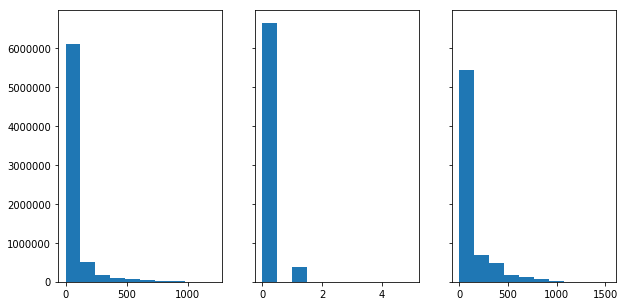

In [158]:
# look at image intensities

this_patient='107'
folder_path=prefix+this_patient

stir=nib.load(folder_path+'/'+this_patient+'_stir.nii')
t1=nib.load(folder_path+'/'+this_patient+'_t1r.nii')
seg=nib.load(folder_path+'/'+this_patient+'_seg.nii.gz')

stir_data = stir.get_fdata()
stir_data=stir_data.astype(int, casting='unsafe')

t1_data = t1.get_fdata()
t1_data=t1_data.astype(int, casting='unsafe')

seg_data = seg.get_fdata()
seg_data=seg_data.swapaxes(0,1)                # this data is oriented differently than the t1's and stirs
seg_data=np.flipud(seg_data)                   # keep this in mind for later
seg_data=seg_data.astype(int, casting='unsafe')

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(10,5))
ax[0].hist(stir_data.ravel());
ax[1].hist(seg_data.ravel());
ax[2].hist(t1_data.ravel());